This notebook loads a trained model and deploys it using the appropriate test dataset

In [28]:
import os
import torch
import numpy as np
import cv2 as cv
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# My stuff
import ae
import utils
from dataloader import LArCV_loader

In [4]:
# Set the root path of the particle generator experiments folder
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

In [5]:
# Set the dir of the particular experiment to be deployed
exp_dir = "12-31-2019_15-39-30_ae_7500_epochs_LArCV_64_dataset/"

In [6]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir)
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/12-31-2019_15-39-30_ae_7500_epochs_LArCV_64_dataset/


In [7]:
# Path to model weights
weights_dir = "weights/"

In [8]:
# Path to the test data
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/"

In [9]:
# Set up the torch dataloader
loader_kwargs = {'num_workers' : 2, 'batch_size': 1}
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
test_dataset    = LArCV_loader(root = test_data, transforms = test_transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [10]:
dataloader = DataLoader(test_dataset, **loader_kwargs)

In [11]:
# Set the GPU (GPU 1 is the best option)
device = torch.device(1)

In [12]:
# Load the config csv as a dict
# config_csv = exp_path + "config.csv"
# config_df = pd.read_csv(config_csv, delimiter = ",")

In [13]:
# Get the model architecture
# ...

In [14]:
# Get checkpoint name(s)
checkpoint_path = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [15]:
best_checkpoint = None
if len(checkpoint_names) == 1:
    best_checkpoint = checkpoint_names[0]

In [16]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(best_checkpoint)

In [59]:
# Get kwargs
# ae_kwargs, config = utils.ae_kwargs(config)
enc_sizes = [2048, 1024, 512, 256]
dec_sizes = [256, 512, 1024, 2048]
l_dim = 20
im_size = 64**2
ae_kwargs = { "enc_sizes" : enc_sizes, "dec_sizes" : dec_sizes, "l_dim" : l_dim, "im_size": im_size}

In [60]:
# Load the model on GPU
model = ae.AutoEncoder(**ae_kwargs).to(device)

In [61]:
# Load the model's state dictionary
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [62]:
# Put the model in evaluation mode
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (fc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4096, out_features=2048, bias=True)
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Linear(in_features=2048, out_features=1024, bias=True)
        (1): ReLU(inplace)
      )
      (2): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): ReLU(inplace)
      )
      (3): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU(inplace)
      )
    )
    (last): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        

In [93]:
test_ims = []; samples = []; limit = 7

for idx, image in enumerate(dataloader):
    # Flatten image into a vector
    image = image.view(1, -1).to(device)
    
    # Get sample from model
    sample = model(image)
        
    # Undo image normalization
#     image = (image * 0.5) + 0.5
#     sample = (sample * 0.5) + 0.5
    
    # Remove the gradient requirement, move to cpu memory, and conver to numpy
    image = image.view(-1, 64, 64).detach().cpu().numpy()
    sample = sample.view(-1, 64, 64).detach().cpu().numpy()
    
    # Concatenate the two images along the channel dimension and append to list
    test_ims.append(image)
    samples.append(sample)
    
    if idx == limit:
        break

In [94]:
# Check samples list
print(len(samples)); print(samples[0][0].shape); print(len(test_ims)); print(test_ims[0][0].shape)

8
(64, 64)
8
(64, 64)


### Visualize the deploy samples

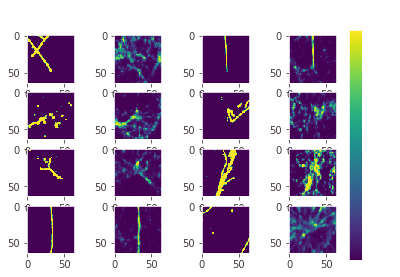

In [95]:
n_row = 4; n_col = 4
fig, axes = plt.subplots(n_row, n_col)
supTitle = "{} Model deploy samples using {}x{} dataset".format('AE', 64, 64)
fig.suptitle(supTitle, color="white")
img = None; test_num = limit; sample_num = limit
for i in range(0, n_row):
    for j in range(0, n_col):
        if j == 0:
            img = axes[i,j].imshow( test_ims[test_num][0] )
            test_num -= 1
        elif j == 1:
            img = axes[i,j].imshow( samples[sample_num][0] )
            sample_num -= 1
        elif j == 2:
            img = axes[i,j].imshow( test_ims[test_num][0] )
            test_num -= 1
        else:
            img = axes[i,j].imshow( samples[sample_num][0] )
            sample_num -= 1
        axes[i,j].spines['bottom'].set_color('white')
        axes[i,j].spines['top'].set_color('white')
        axes[i,j].spines['left'].set_color('white')
        axes[i,j].spines['right'].set_color('white')
        axes[i,j].xaxis.label.set_color('white')
        axes[i,j].yaxis.label.set_color('white')
        axes[i,j].tick_params(axis='x', colors='#443941')
        axes[i,j].tick_params(axis='y', colors='#443941')

# Colorbar
cbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cbar = plt.colorbar(img, cax=cbar_axes)
cbar.ax.yaxis.set_tick_params(color="white")
cbar.outline.set_edgecolor(color="white")
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color="white")

plt.savefig("{}_model_deploy_samples_{}_dataset.png".format('AE', 64), dpi=300, facecolor='#443941')